# ConvLSTM model

Import libraries and modules.

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Enable interactive widgets in Jupyter Notebook
%matplotlib widget
import torch.nn as nn
# import torch.nn.functional as F

# from numba import jit, prange
# from PIL import Image
import importlib  
from torch.utils.data.dataset import random_split
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
# from matplotlib.colors import TwoSlopeNorm

from ConvLSTM_pytorch.convlstm import ConvLSTM
from encode_decode_csv import decode_from_csv

SyntaxError: invalid syntax (convlstm.py, line 1)

Check if GPU is available.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [ ]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are stored not in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [ ]:
# training and validation dataset
inputs, targets = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 3, 64, 64])
Restored targets Shape: torch.Size([80, 2, 97, 64, 64])


In [ ]:
# test dataset 1
inps1, targs1 = decode_from_csv(test1)

Restored inputs Shape: torch.Size([20, 3, 64, 64])
Restored targets Shape: torch.Size([20, 2, 97, 64, 64])


In [ ]:
# test dataset 2
inps2, targs2 = decode_from_csv(test2)

Restored inputs Shape: torch.Size([21, 3, 64, 64])
Restored targets Shape: torch.Size([21, 2, 97, 64, 64])


In [ ]:
# test dataset 3
inps3, targs3 = decode_from_csv(test3)

Restored inputs Shape: torch.Size([10, 3, 128, 128])
Restored targets Shape: torch.Size([10, 2, 97, 128, 128])


Text(0.5, 1.0, 'Water Depth time step 0')

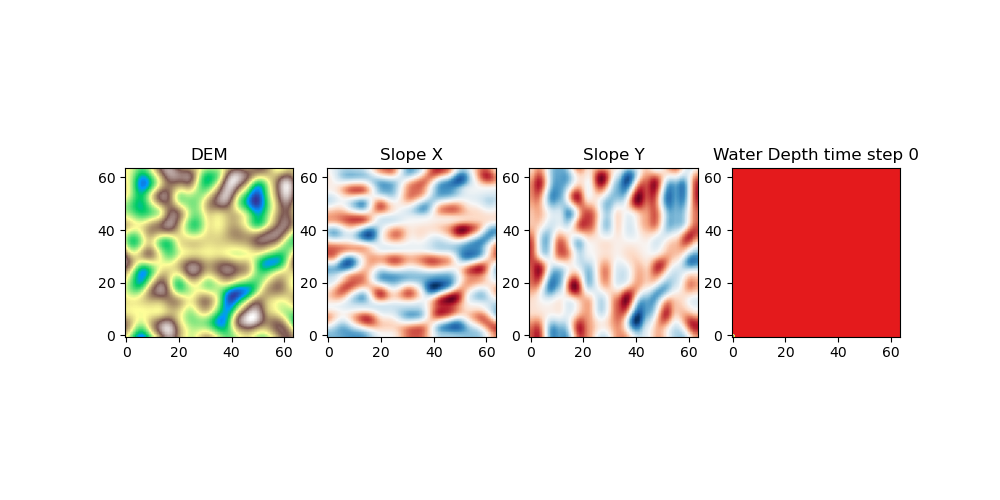

In [ ]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0

axs[0].imshow(inputs[numb][0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[numb][1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(inputs[numb][2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

# kept it simple and did not include this in the inputs, but for generalization, this should be an input
# Discharge is just zeros, probably redundant
axs[3].imshow(targets[numb][0][0].cpu(), cmap='Set1', origin='lower')
axs[3].set_title('Water Depth time step 0')

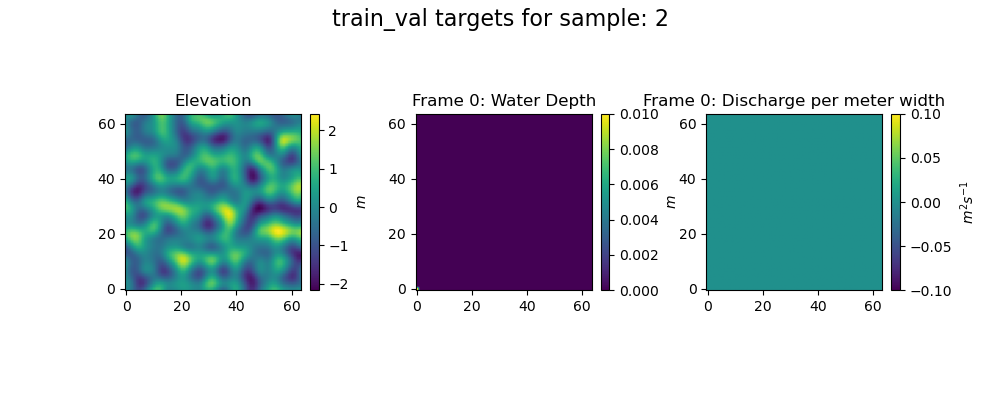

In [ ]:
# change following independent variables #
target_tensor = targets
input_tensor = inputs
title_anim = train_val
sample = 2
feature1 = 0
feature2 = 1
# -------------------------------------- #

feature_dic = {
    0: 'Water Depth',
    1: 'Discharge per meter width'
}

feature_dic_units = {
    0: r'$m$',
    1: r'$m^2 s^{-1}$'
}


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

# Subplot 1
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', '5%', '5%')

static_tensor = input_tensor[sample, 0] # index 0 refers to elevation
im1 = ax1.imshow(static_tensor, origin='lower')
cb1 = fig.colorbar(im1, cax=cax1)
cb1.set_label(r'$m$')
ax1.set_title('Elevation')

# Subplot 2
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', '5%', '5%')

animated_tensor1 = target_tensor[sample, feature1]
im2 = ax2.imshow(animated_tensor1[0], origin='lower')
cb2 = fig.colorbar(im2, cax=cax2)
cb2.set_label(f'{feature_dic_units[feature1]}')
tx2 = ax2.set_title(f'Frame 0: {feature_dic[feature1]}')

# Subplot 3
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', '5%', '5%')

animated_tensor2 = target_tensor[sample, feature2]
im3 = ax3.imshow(animated_tensor2[0], origin='lower')
cb3 = fig.colorbar(im3, cax=cax3)
cb3.set_label(f'{feature_dic_units[feature2]}')
tx3 = ax3.set_title(f'Frame 0: {feature_dic[feature2]}')

main_title = fig.suptitle(title_anim + f' targets for sample: {sample}', fontsize=16)

def animate(i):
    # Subplot 2
    arr1 = animated_tensor1[i]
    max_val1 = arr1.max()
    min_val1 = arr1.min()
    im2.set_data(arr1)
    im2.set_clim(min_val1, max_val1)
    tx2.set_text(f'Frame {i}: {feature_dic[feature1]}')

    # Subplot 3
    arr2 = animated_tensor2[i]
    max_val2 = arr2.max()
    min_val2 = arr2.min()
    im3.set_data(arr2)
    im3.set_clim(min_val2, max_val2)
    tx3.set_text(f'Frame {i}: {feature_dic[feature2]}')

ani = animation.FuncAnimation(fig, animate, frames=target_tensor.shape[2])

plt.show()

In [ ]:
# # Save the animation as a gif
# ani.save('example.gif', writer='Pillow', fps=20)

In [ ]:
def normalize_in_or_tar(in_or_tar, scaler_x, scaler_y):
    if len(in_or_tar.shape) == 4: # inputs, only use scalar x  
        min_var, max_var = scaler_x.data_min_[0], scaler_x.data_max_[0]
    elif len(in_or_tar.shape) == 5: # targets, only use scalar y
        min_var, max_var = scaler_y.data_min_[0], scaler_y.data_max_[0]
    else:
        raise Exception("Something is wrong with encoder/decoder")
    normalized_in_or_out = []
    for idx in range(in_or_tar.shape[0]):
        var = in_or_tar[idx]
        norm_var = (var - min_var) / (max_var - min_var)
        normalized_in_or_out.append(norm_var)
    return torch.stack(normalized_in_or_out, dim=0)

In [ ]:
# Normalize the inputs and targets using training dataset
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

for idx in range(inputs.shape[0]):
    scaler_x.partial_fit(inputs[idx].reshape(inputs.shape[1], -1).T.cpu())
    scaler_y.partial_fit(targets[idx].reshape(targets.shape[1], -1).T.cpu())

normalized_inputs = normalize_in_or_tar(inputs, scaler_x, scaler_y)
normalized_inputs = normalized_inputs.unsqueeze(2) # new shape to make the model understand there is only one timestep
normalized_targets = normalize_in_or_tar(targets, scaler_x, scaler_y)

In [ ]:
# create a dataset to split randomly for train and val
# place timesteps in index position 1, features position 2, I think this is what convlstm is expecting
my_dataset = TensorDataset(normalized_inputs.permute(0, 2, 1, 3, 4), normalized_targets.permute(0, 2, 1, 3, 4))

In [ ]:
my_dataset[79][0].shape # first position is the samples, second decides between inputs or targets, notice new shape of inputs

torch.Size([1, 3, 64, 64])

In [ ]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * inputs.shape[0])
val_size = inputs.shape[0] - train_size
train_dataset, val_dataset = random_split(my_dataset, [train_size, val_size])

In [ ]:
# Model, check, not sure num_layers is the expected amount of outputs
model = ConvLSTM(input_dim = inputs.shape[1], hidden_dim = 2, kernel_size = (3, 3), num_layers = 2,
         batch_first=True, bias=False, return_all_layers = True).to(device)
# return all layers has to be true to obtain all the outputs I think

In [ ]:
model

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1-7): 7 x ConvLSTMCell(
      (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
)

In [ ]:
def train_epoch(model, loader, optimizer, device='cpu'):
    model.float()
    model.train()  # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0].float().to(device)
        y = batch[1].float().to(device)

        # Initialize a variable to store previous output
        prev_output = None

        # Model prediction for each time step
        for t in range(y.size(1)):
            if prev_output is not None:
                #x_t = torch.cat([x, prev_output], dim=1)
                x_t = prev_output # use previous output as current input
            else:
                x_t = x.to(torch.float32)  # For the first time step
            print(x_t)
            # Model forward pass
            layer_outputs, _ = model(x_t) # hidden state not implemented in py file can't use as input

            # Choose the output from the desired layer (e.g., last layer)
            desired_layer_output = layer_outputs[-1]

            # MSE loss function
            loss = nn.MSELoss()(desired_layer_output, y[:, t, :, :, :].unsqueeze(1))

            losses.append(loss.cpu().detach())

            # Use the current output as the input for the next time step
            prev_output = desired_layer_output.detach()

            # Backpropagate and update weights for every time step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    losses = np.array(losses).mean()

    return losses

## Once train_epoch works change evaluation accordingly

In [ ]:
def evaluation(model, loader, device='cpu'):
    model.eval() # specifies that the model is in evaluation mode
    
    losses = []
    
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            

            # Model prediction for each time step
            for t in range(y.size(1)):
                None
    losses = np.array(losses).mean()

    return losses

In [ ]:
# Set training parameters
learning_rate = 0.001
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small
num_epochs = 10

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch%10 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4))
        
model = copy.deepcopy(best_model)

tensor([[[[[0.4818, 0.4994, 0.5199,  ..., 0.3238, 0.3189, 0.3572],
           [0.4797, 0.4974, 0.5219,  ..., 0.3296, 0.3151, 0.3436],
           [0.4986, 0.5115, 0.5290,  ..., 0.3626, 0.3329, 0.3402],
           ...,
           [0.4707, 0.4455, 0.4245,  ..., 0.5325, 0.5179, 0.5002],
           [0.4785, 0.4671, 0.4552,  ..., 0.4906, 0.4834, 0.4748],
           [0.4859, 0.4866, 0.4832,  ..., 0.4510, 0.4556, 0.4595]],

          [[0.4797, 0.4798, 0.4838,  ..., 0.4876, 0.4780, 0.4681],
           [0.4902, 0.4878, 0.4863,  ..., 0.5012, 0.4887, 0.4733],
           [0.5070, 0.4997, 0.4874,  ..., 0.5280, 0.5136, 0.4899],
           ...,
           [0.4873, 0.4999, 0.5078,  ..., 0.4495, 0.4531, 0.4586],
           [0.4894, 0.5023, 0.5111,  ..., 0.4410, 0.4506, 0.4614],
           [0.4892, 0.5013, 0.5098,  ..., 0.4421, 0.4539, 0.4665]],

          [[0.4994, 0.5008, 0.4995,  ..., 0.4567, 0.4985, 0.5201],
           [0.4995, 0.5029, 0.5059,  ..., 0.4486, 0.4887, 0.5102],
           [0.4947, 0.4970

RuntimeError: Given groups=1, weight of size [8, 5, 3, 3], expected input[4, 4, 64, 64] to have 5 channels, but got 4 channels instead